# AA-тест

До проведения AB-тестирования и проверки гипотез, необходимо убедиться в корректности разделения пользователей на группы. Рассматриваемый показатель не должен отличаться в группах. Для проверки системы сплитования необходимо проведение AA- теста


**Задачи** : По данным с '2024-07-26' по '2024-08-01':

1. Необходимо провести симуляцию 10000 А/А-тестов.
1. Построить гистограмму распределения получившихся 10000 p-values.
2. Посчитать, какой процент p values оказался меньше либо равен 0.05
3. Определить, корректно ли работает наша система сплитования.

**Рассмтариваемый показатель** : CTR

In [1]:
import pandas as pd
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


sns.set_style("whitegrid", {"axes.facecolor": "white"})

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20240820',
'user':'student',
'password':'dpo_python_2020'
}

#текст запроса
query = '''
select user_id, countIf(action='view')  as views, countIf(action='like')  as likes, countIf(action='like')/countIf(action='view') as ctr, exp_group
from simulator_20240820.feed_actions
where toDate(time) between '2024-07-26' and '2024-08-01' and exp_group in [2,3]
group by user_id, exp_group
'''

# эта функция выполнит запрос и запишет его результат в pandas DataFrame
df = ph.read_clickhouse(query, connection=connection)

In [3]:
df.head()

,user_id,views,likes,ctr,exp_group
0,115383,248,38,0.153226,3
1,10326,132,24,0.181818,3
2,123580,122,25,0.204918,3
3,131473,98,19,0.193878,2
4,23985,44,12,0.272727,2


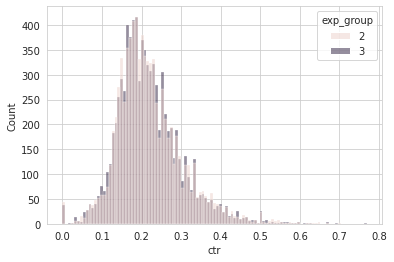

In [4]:
sns.histplot(data=df, x='ctr', hue='exp_group')
plt.show()

Распределение исследуемой величины в двух группах визуально совпадают.

In [5]:
def aa_test(data, num_experiments, num_samples, num_group_1, num_group_2):
    
    p_values = []
    exp_group_1 = data[data['exp_group'] == num_group_1].ctr
    exp_group_2 = data[data['exp_group'] == num_group_2].ctr

    for _ in range(num_experiments):
        sample_exp_group_1 = exp_group_1.sample(n=num_samples)       
        sample_exp_group_2 = exp_group_2.sample(n=num_samples)        
        p_value = stats.ttest_ind(sample_exp_group_1, sample_exp_group_2, equal_var=False).pvalue      
        p_values.append(p_value)
    return p_values

In [6]:
result_ttest = pd.Series(aa_test(df, 10000, 500, 2, 3), name='p-value')

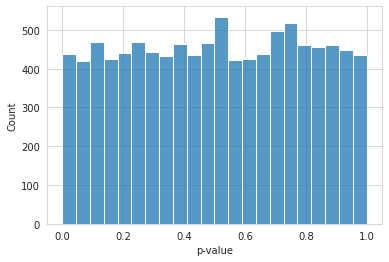

In [7]:
plt.figure()
sns.histplot(result_ttest)
plt.show()

In [8]:
print(f'В {(result_ttest <= 0.05).mean()*100} % случаев p-values меньше или равен 0.05')

В 4.83 % случаев p-values меньше или равен 0.05


## Выводы: 
- При проведении множества AA-тестов статистически значимые различия (p-value <= 0.05) наблюдалосб лишь в  ≈4.5% случаев.  
- Распределение p-value равномерное.

На основании данных выводов, можно сказать, что выбранная система сплитования работает корректно. Статистически значимых различий между группами не наблюдается.  